# Setup

In [1]:
# you can install new packages using pip commands
# bangs (!) are needed when you are running cmd commands
!pip install -U --quiet scikit-learn geopandas #  install (or upgrade if already existing) sklearn

In [2]:
# download the shared .zip file quietly
!wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1j4jIP5N9LxiqZF2oEysMwy7jQO-Obrvk' -O- | sed -rn 's/.confirm=([0-9A-Za-z_]+)./\1\n/p')&id=1j4jIP5N9LxiqZF2oEysMwy7jQO-Obrvk" -O "datasets_full.zip"

# unzip the shared .zip file quietly
!unzip -q -n "datasets_full.zip"

In [6]:
# download shape files for the boroughs
!wget -q https://data.london.gov.uk/download/statistical-gis-boundary-files-london/9ba8c833-6370-4b11-abdc-314aa020d5e0/statistical-gis-boundaries-london.zip -O statistical-gis-boundaries-london.zip
!unzip -qn statistical-gis-boundaries-london.zip

In [7]:
!wget -q https://data.london.gov.uk/download/country-of-birth/c61439c3-32ab-4c7d-941e-366d4ac2c57c/cob-borough.xls -O cob-borough.xls

In [103]:
import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px 

# Data Prep

In [9]:
gdf = gpd.read_file("statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp")

In [88]:
def read_popu_by_country(fname="/content/cob-borough.xls", code_pref=None):
    df_all = pd.DataFrame()
    for year in range(2004, 2019):
        df = pd.read_excel(fname, sheet_name=str(year))

        # adjust column headers, which are spread among multiple rows
        header = np.where(df.iloc[0].isnull(), df.iloc[1], df.iloc[0])
        header = np.where(pd.isnull(header), df.columns, header)
        header[header == "All"] = "All Non EU"
        header = pd.Series(header)
        df.columns = header

        # get rid of confidence columns
        df = df.loc[:, ~header.str.contains("Unnamed").values]

        # get rid of empty rows
        df = df[df["Area Code"].notnull()]

        # coerce error values to NAs
        for col in df.columns[2:]:
            df[col] = pd.to_numeric(df[col], errors="coerce")
        
        # insert a year column
        df.insert(0, "Year", year)

        if code_pref is not None:
            df = df[df["Area Code"].str.startswith(code_pref)]
        
        df_all = df_all.append(df)
    return df_all

In [89]:
df = read_popu_by_country(code_pref="E09")

In [92]:
df.sample(5)

Year  Area Code  ... Central and South America  Oceania
16  2011  E09000013  ...                       5.0      6.0
6   2018  E09000003  ...                       6.0      2.0
4   2018  E09000001  ...                       NaN      NaN
26  2005  E09000023  ...                      17.0      2.0
12  2011  E09000009  ...                       7.0      3.0

[5 rows x 24 columns]

# EDA

## First try

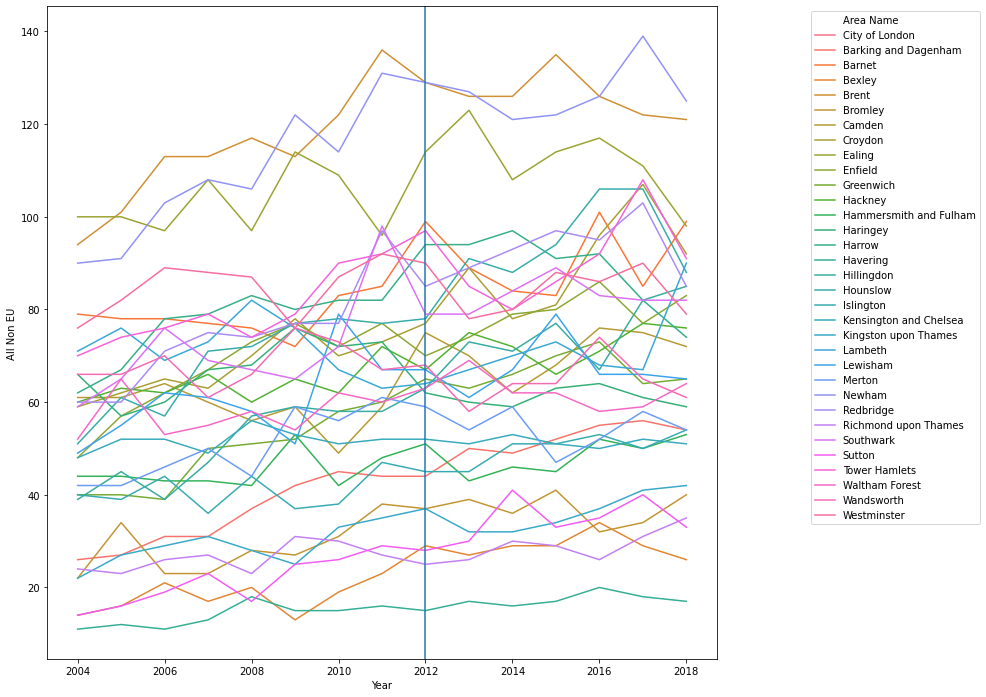

In [102]:
plt.figure(figsize=(12,12))

sns.lineplot(data=df, x="Year", y="All Non EU", hue="Area Name")
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 1))
plt.axvline(x=2012)
plt.show()

## Batches

In [172]:
def plot_in_batches(df, country, area_per_plot=5, col_per_row=3):
    areas = df["Area Name"].drop_duplicates()   
    nrows = np.ceil(len(areas)/ area_per_plot) / col_per_row
    nrows = np.ceil(nrows)
    nrows = int(nrows)
    #print(f"count: {len(areas)}, row: {nrows}, col: {col_per_row}")
    fig, axs = plt.subplots(nrows, col_per_row, figsize=(8*nrows,8*col_per_row))
    for plot_no, i in enumerate(range(0, len(areas), area_per_plot)):
        row_no = plot_no // col_per_row 
        col_no = plot_no % col_per_row

        max_i = min(i+5, len(areas))
        sel = areas[i:max_i]
        
        ax = axs[row_no, col_no]
        sns.lineplot(data=df[df["Area Name"].isin(sel)], x="Year", y=country, hue="Area Name", ax=ax)
        ax.legend(loc="upper right")
        ax.axvline(x=2012)
    fig.show()

### Regional

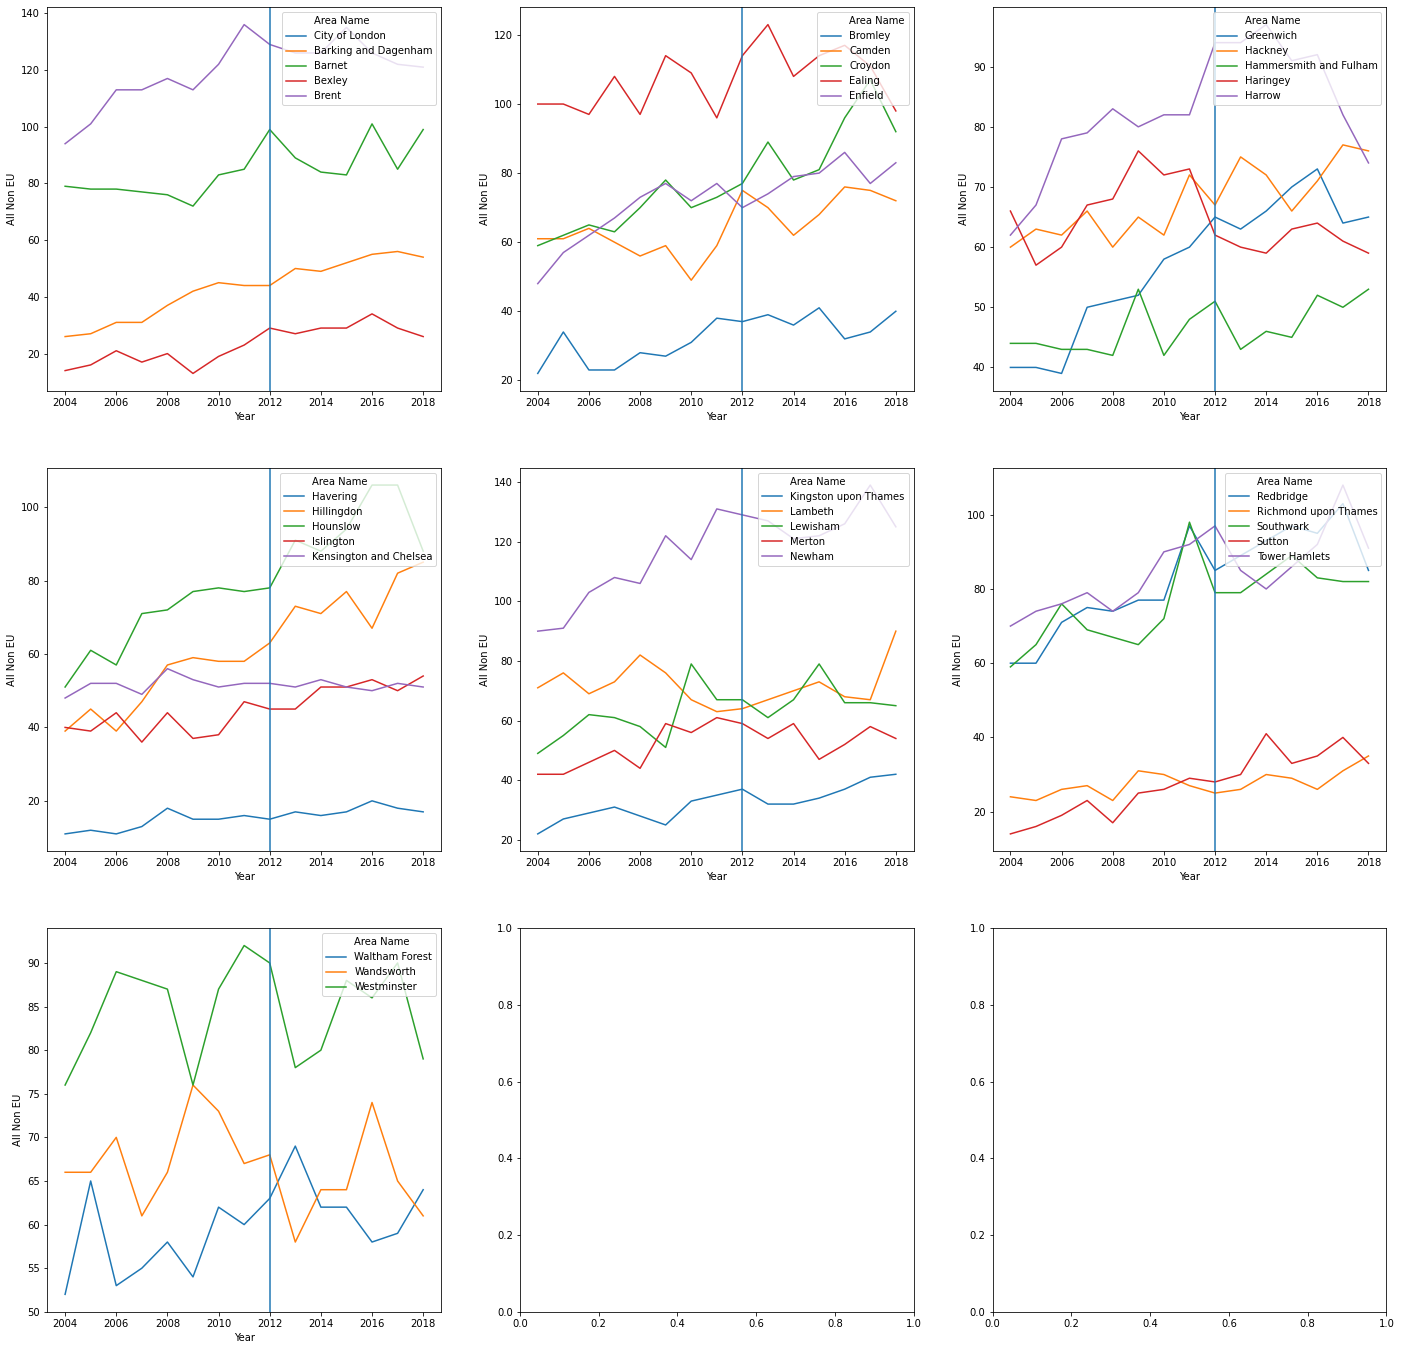

In [173]:
plot_in_batches(df, "All Non EU")

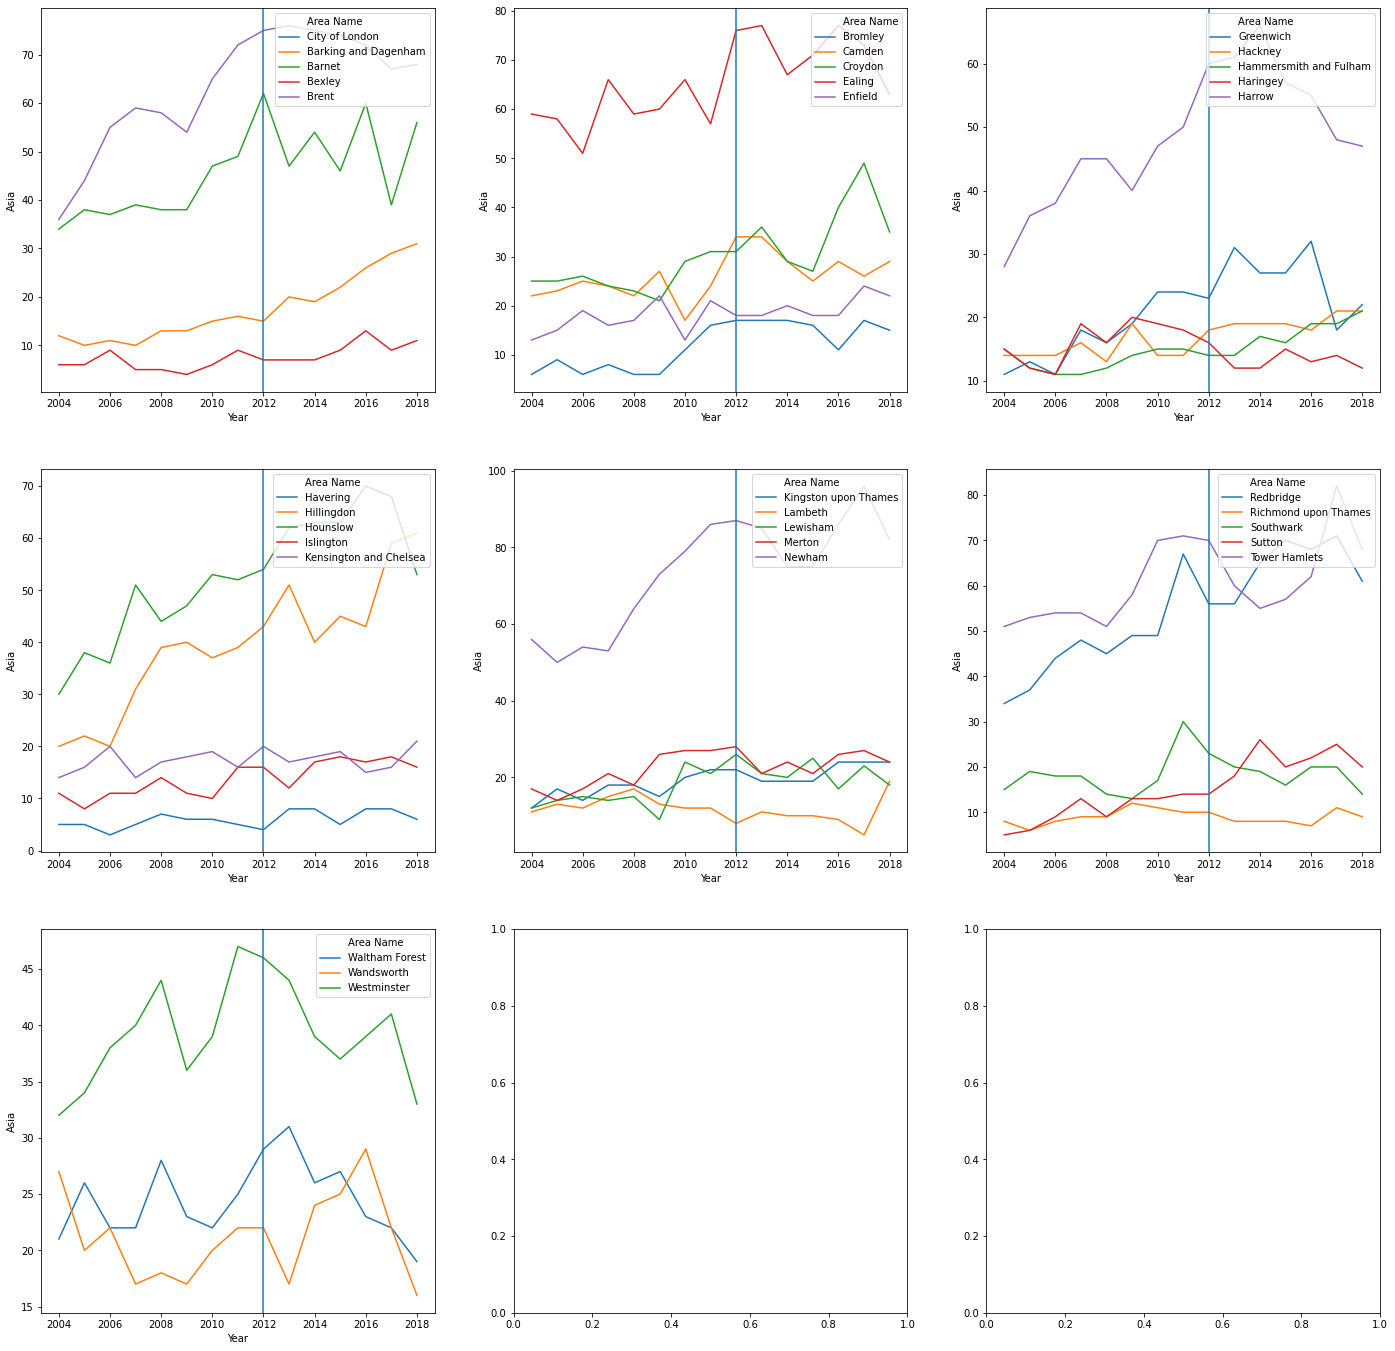

In [174]:
plot_in_batches(df, "Asia")

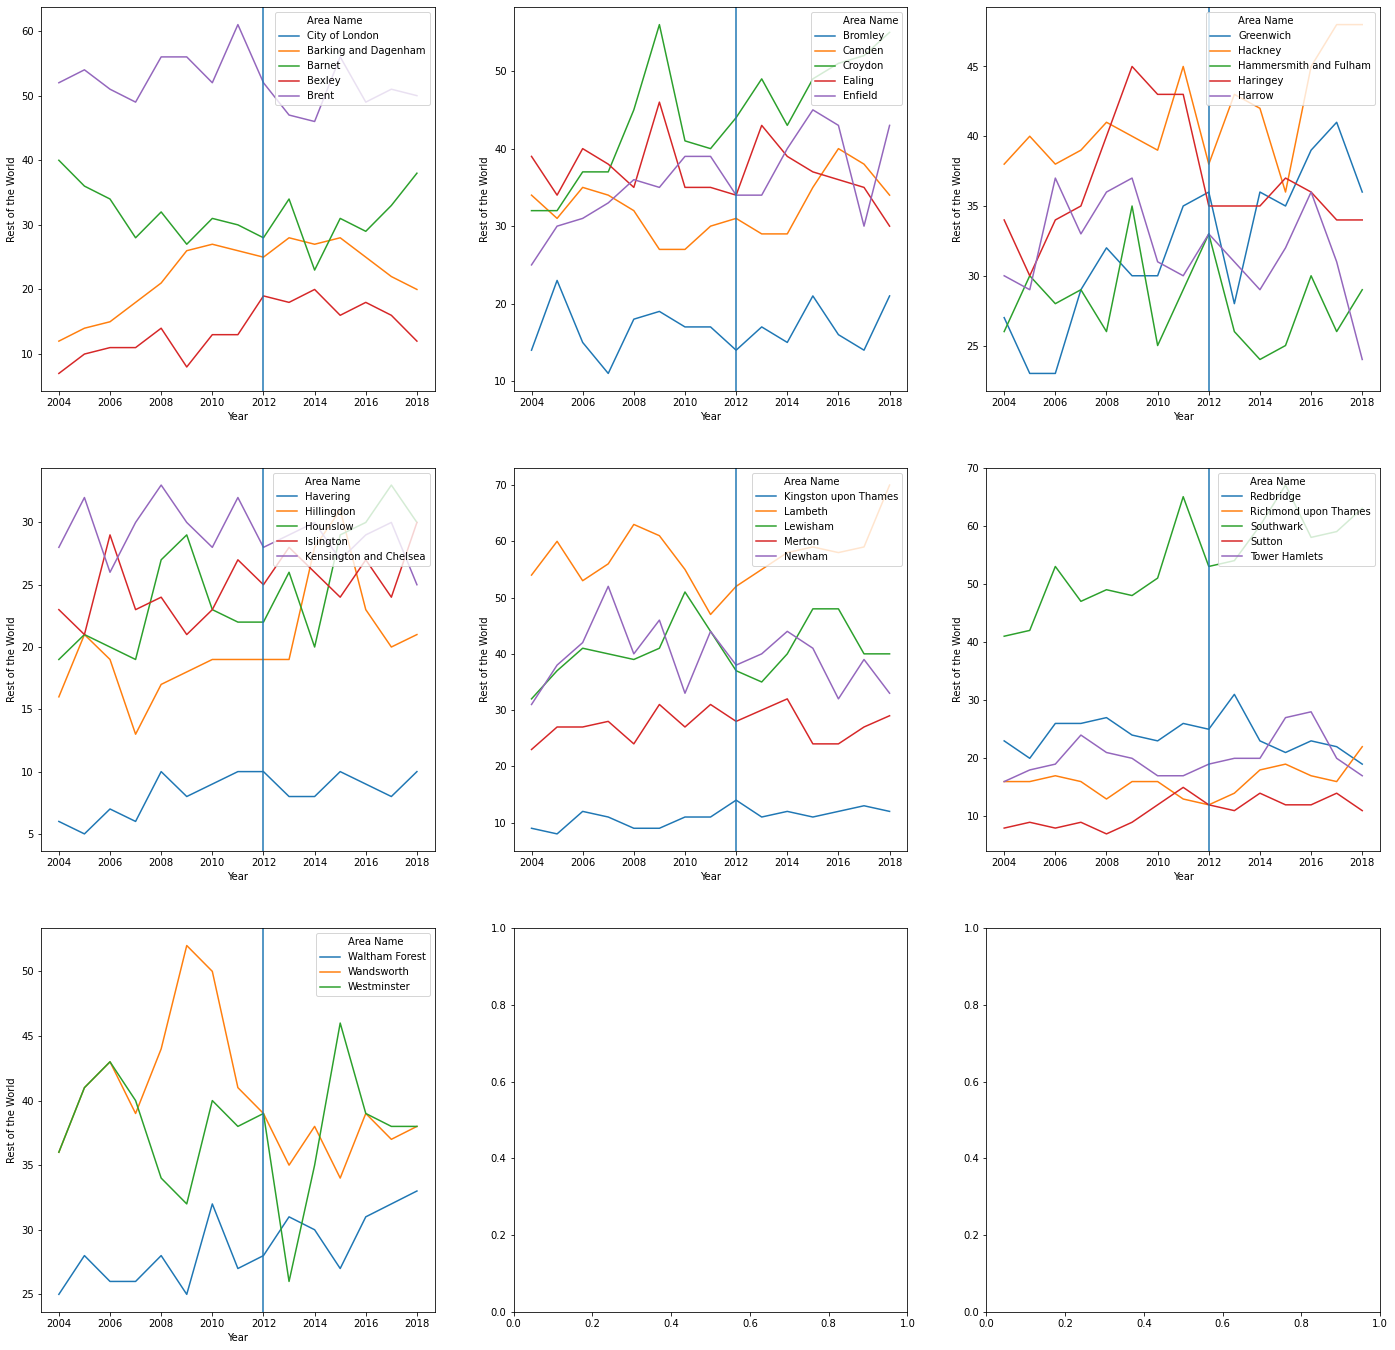

In [175]:
plot_in_batches(df, "Rest of the World")

### Subregions

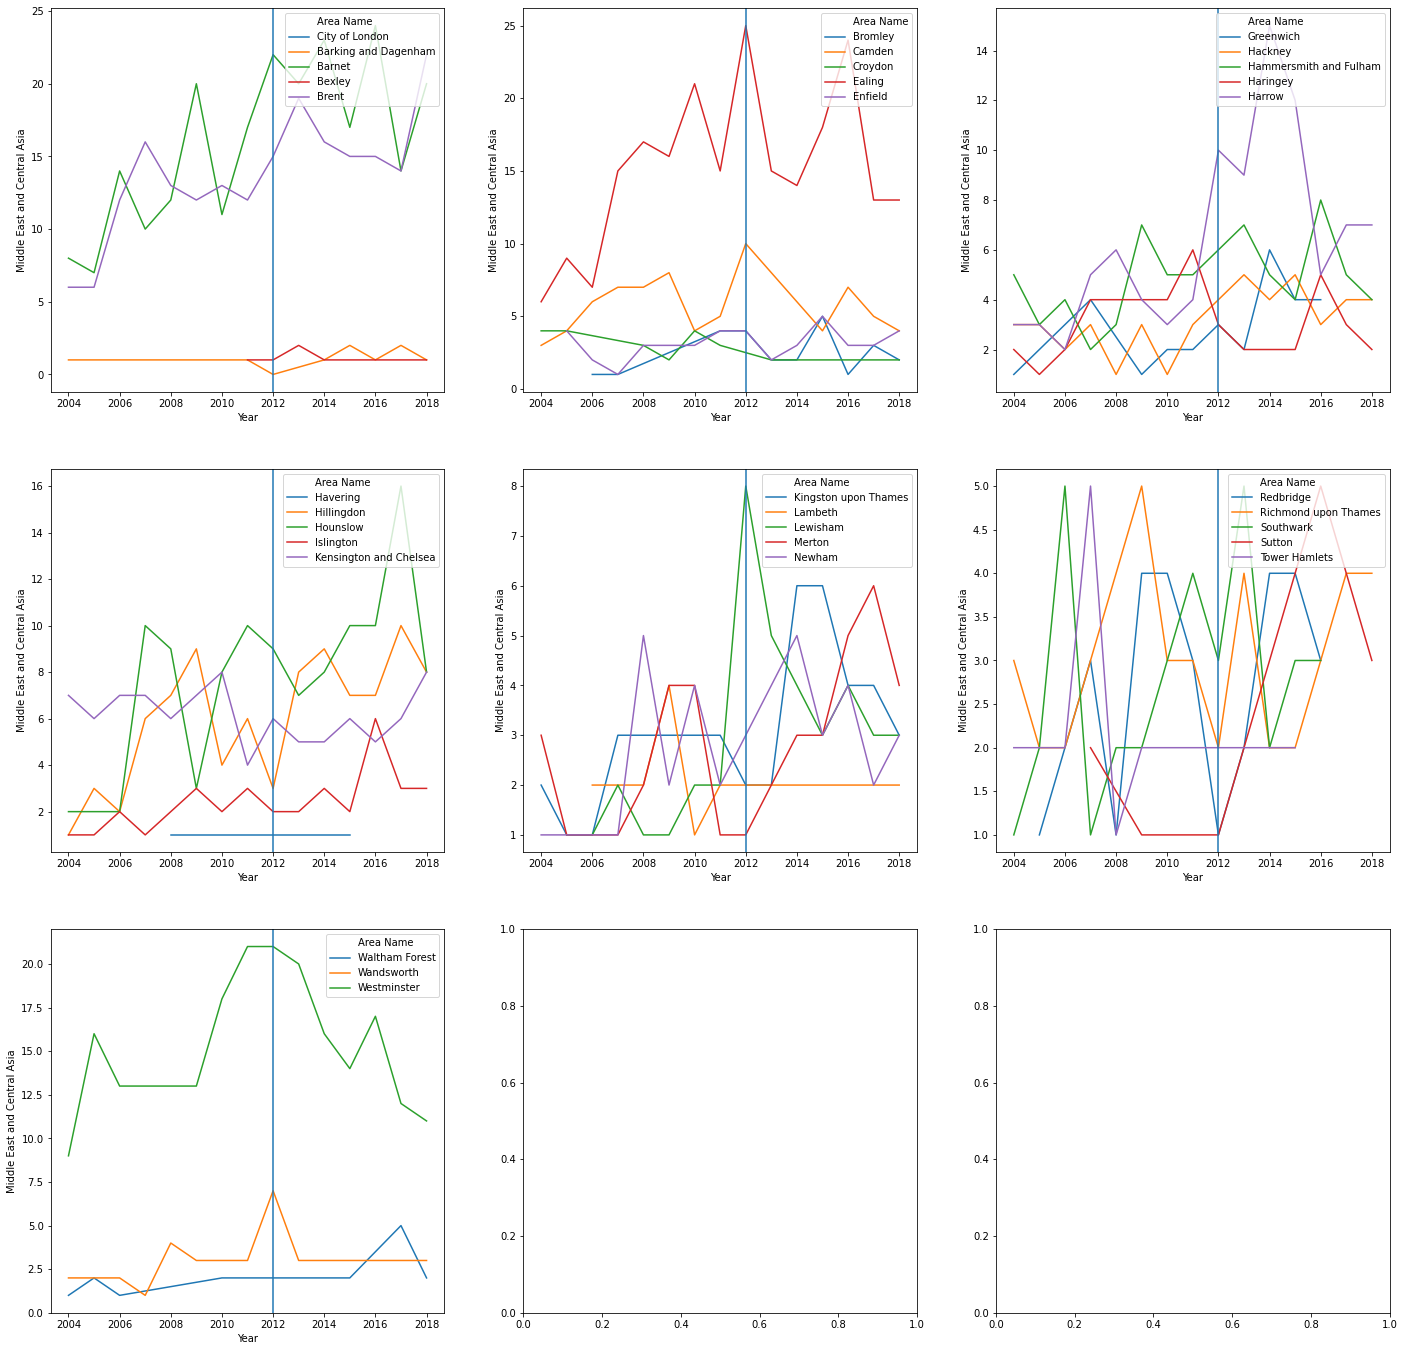

In [176]:
plot_in_batches(df, "Middle East and Central Asia")

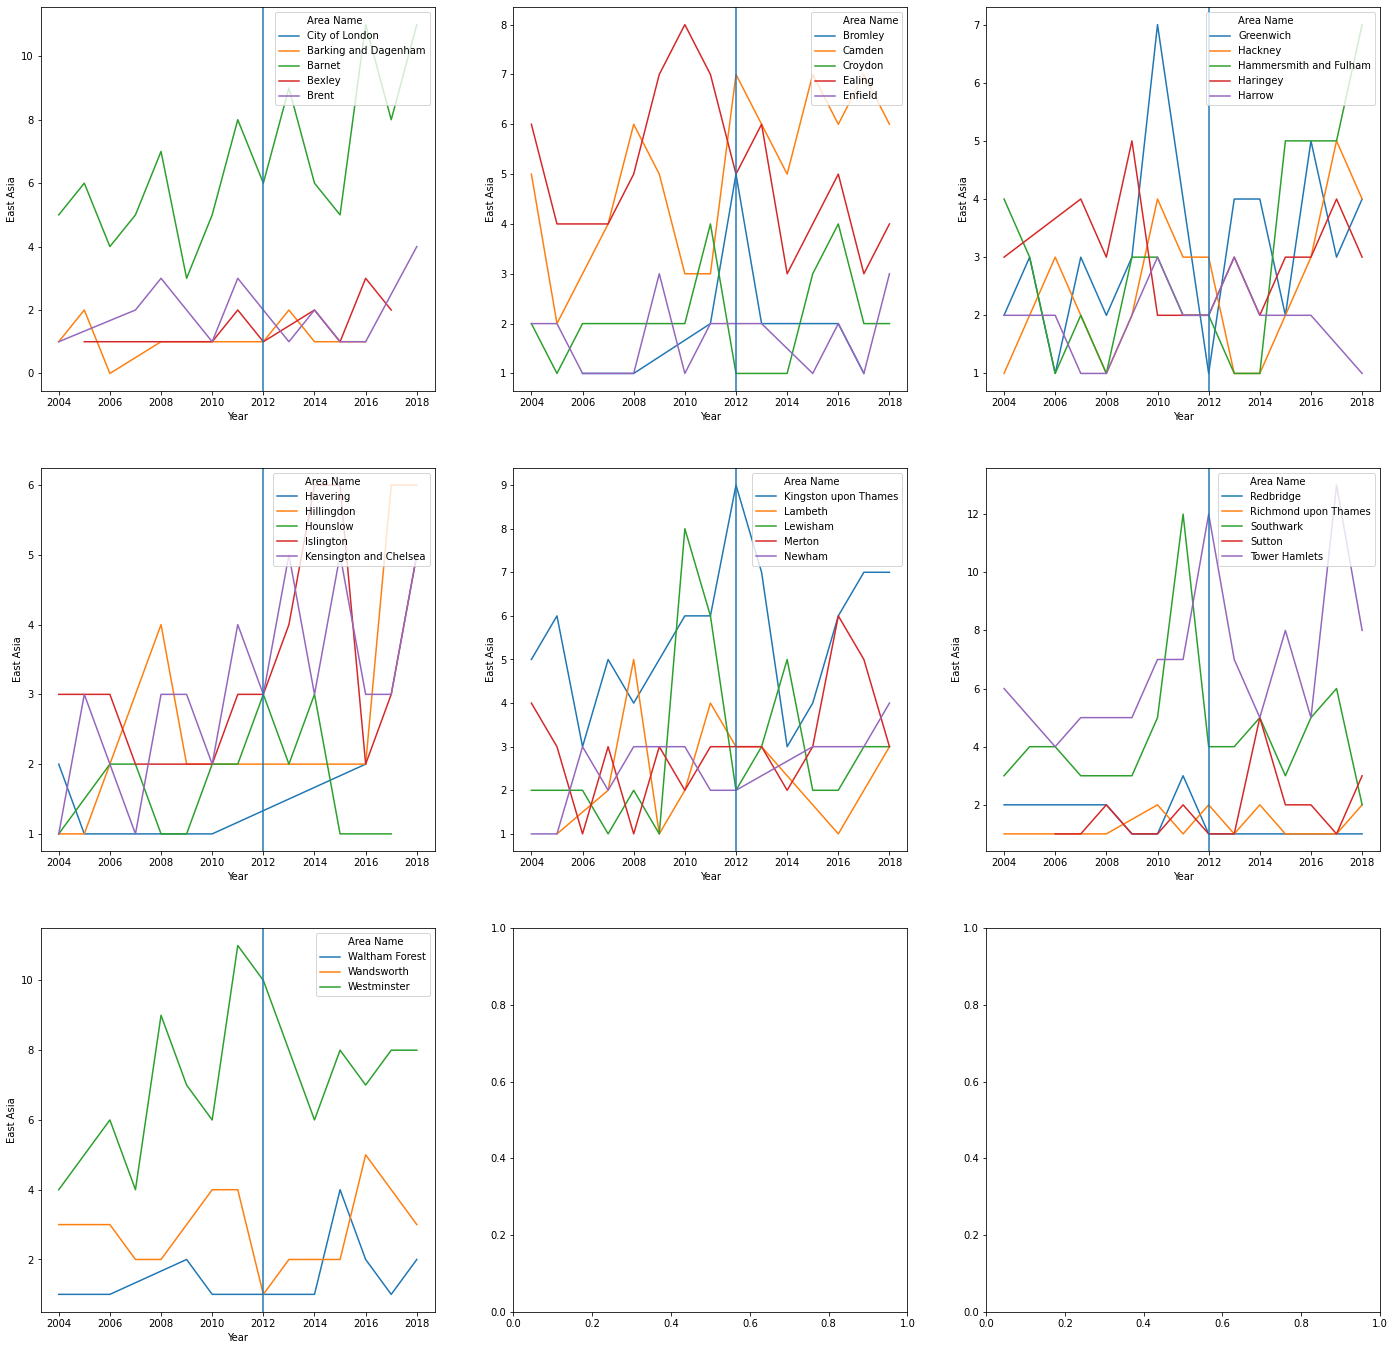

In [177]:
plot_in_batches(df, "East Asia")

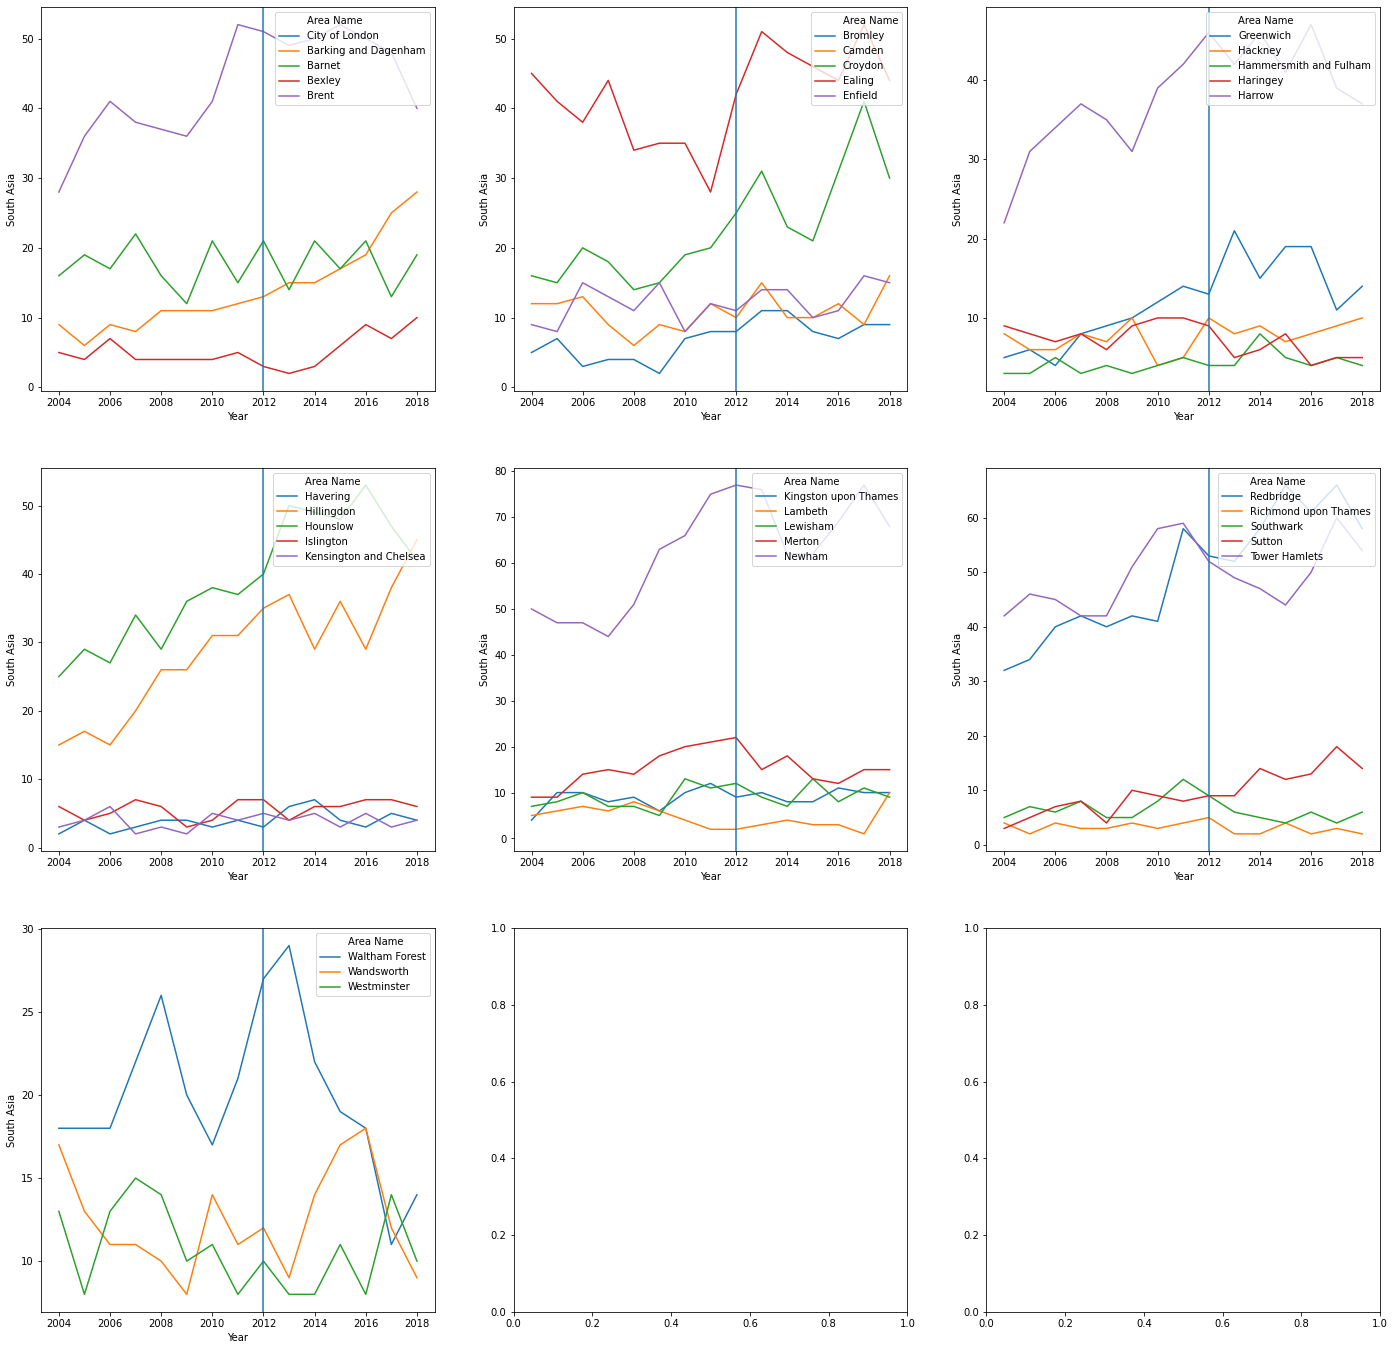

In [178]:
plot_in_batches(df, "South Asia")

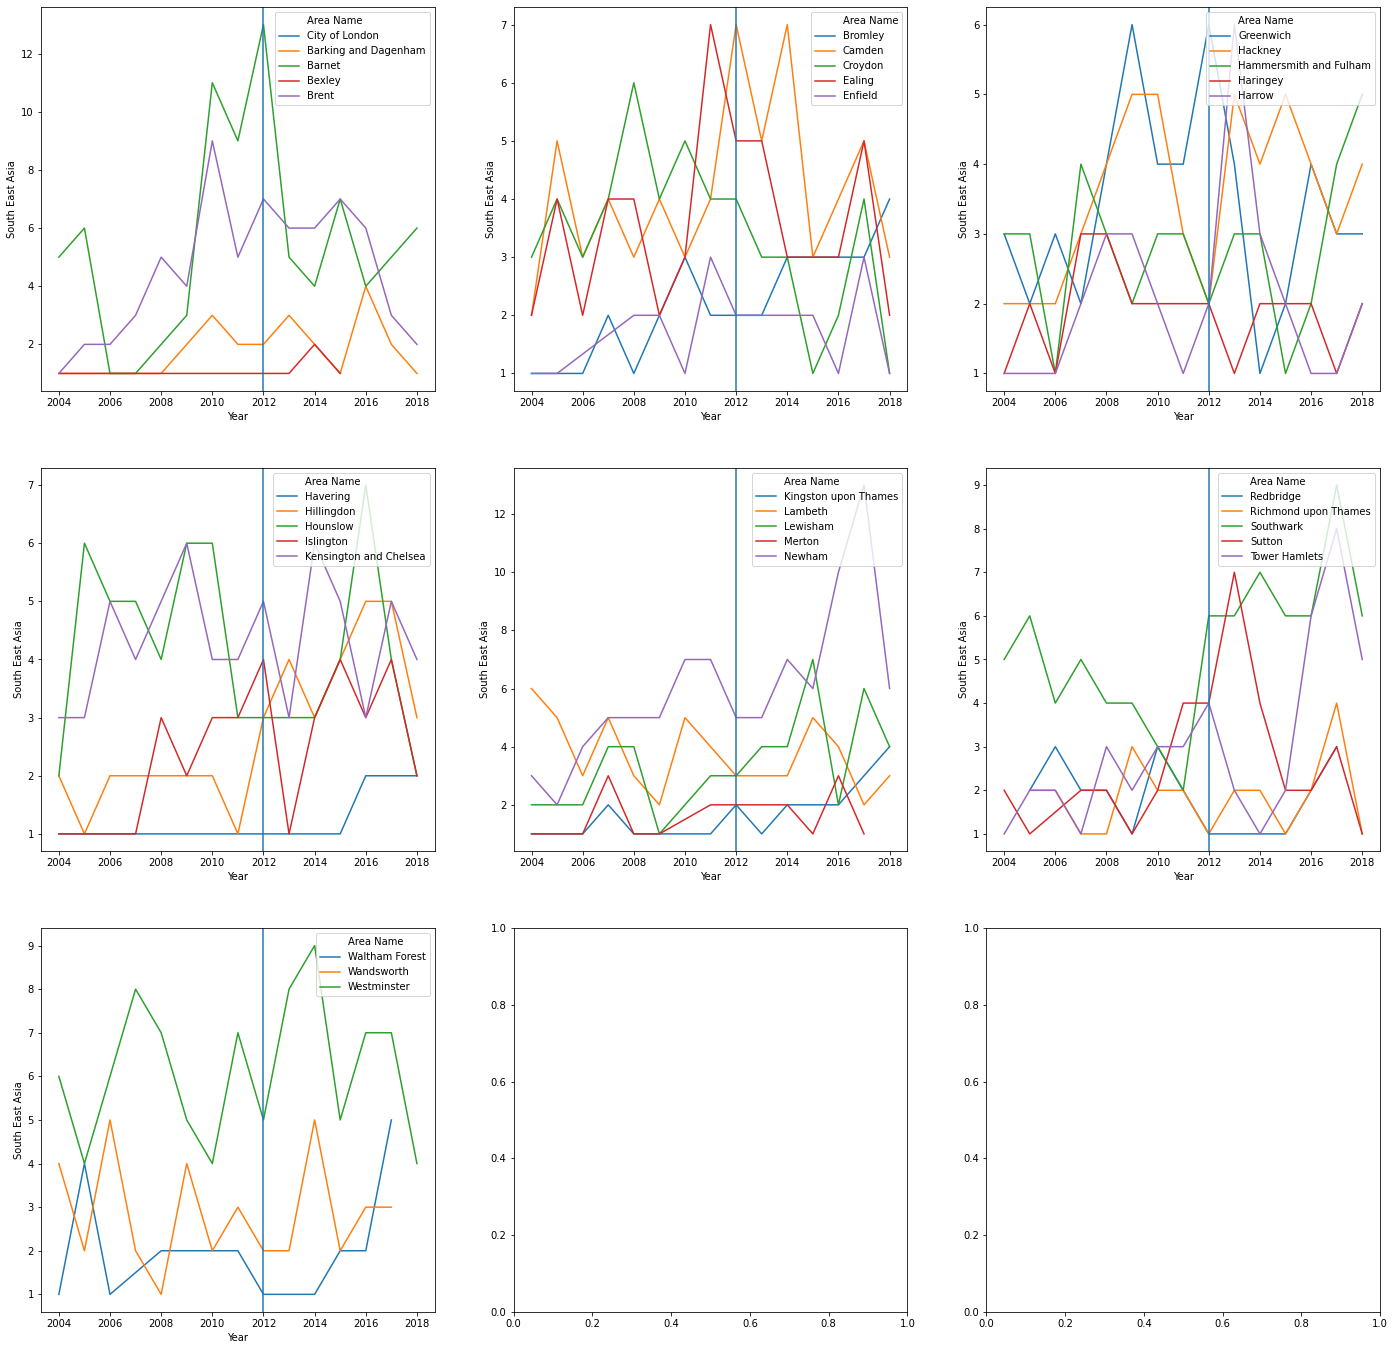

In [179]:
plot_in_batches(df, "South East Asia")

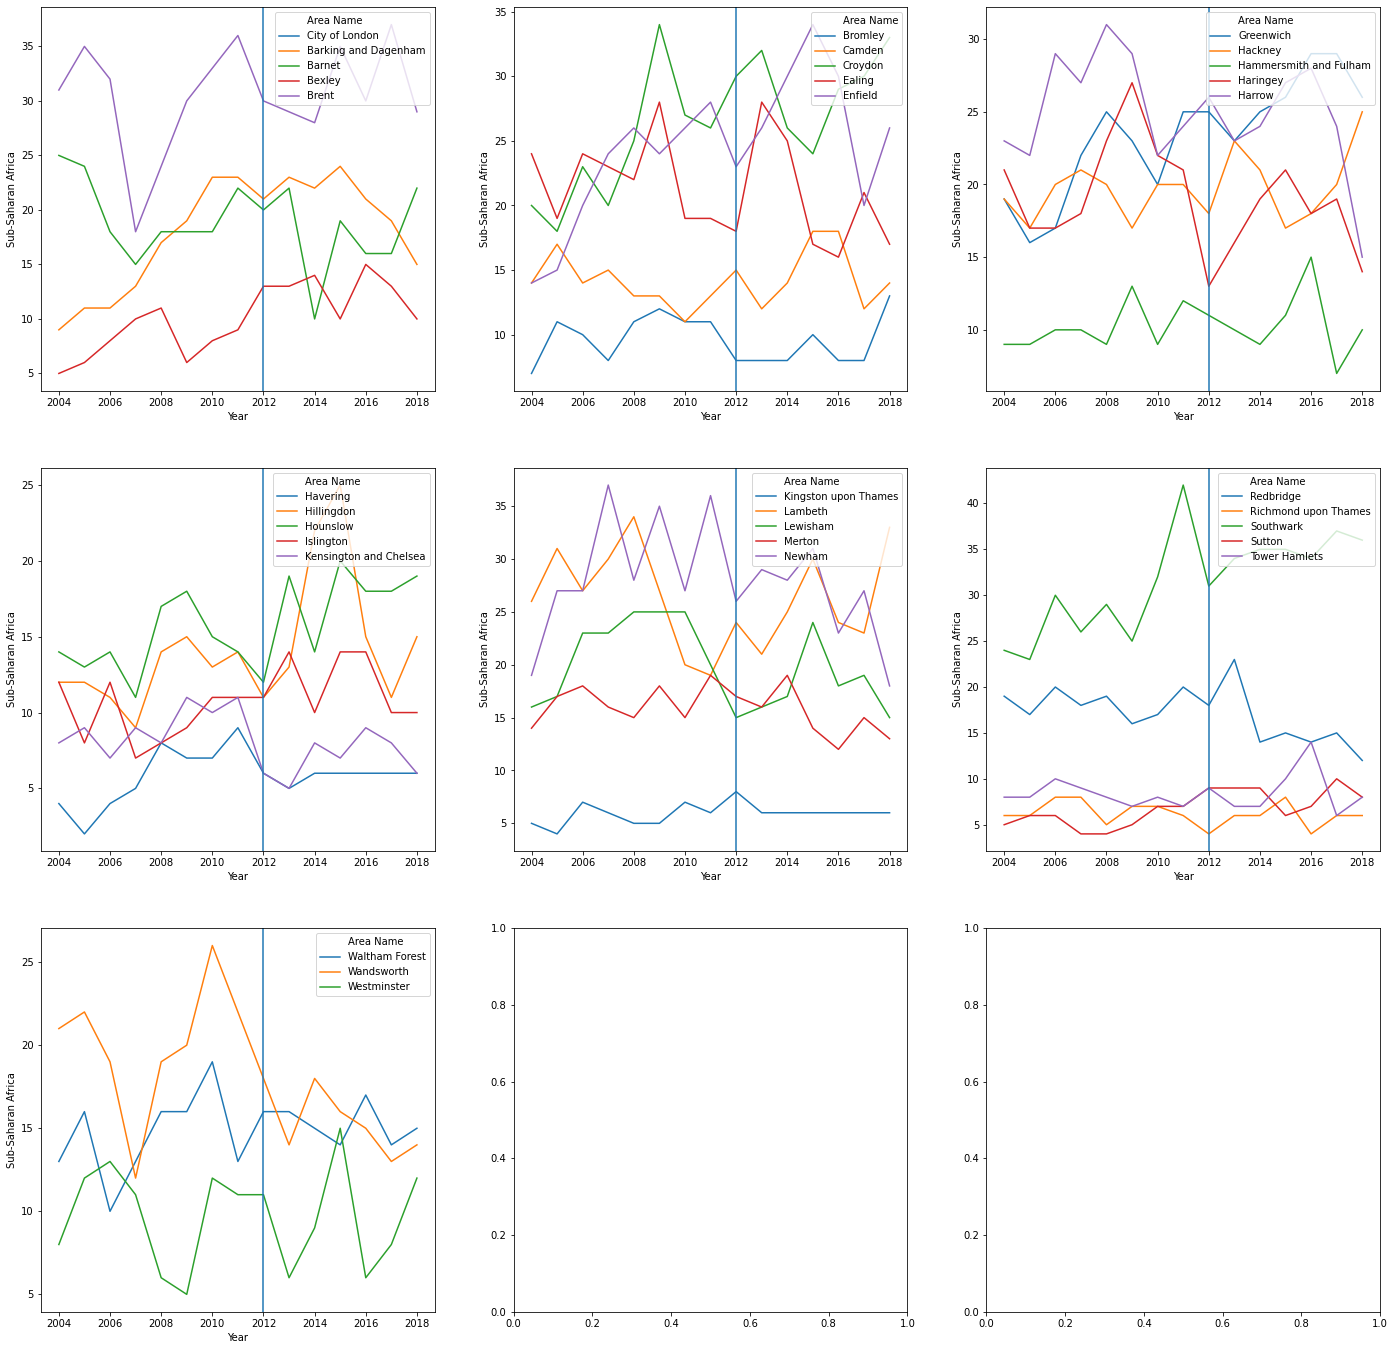

In [180]:
plot_in_batches(df, "Sub-Saharan Africa")

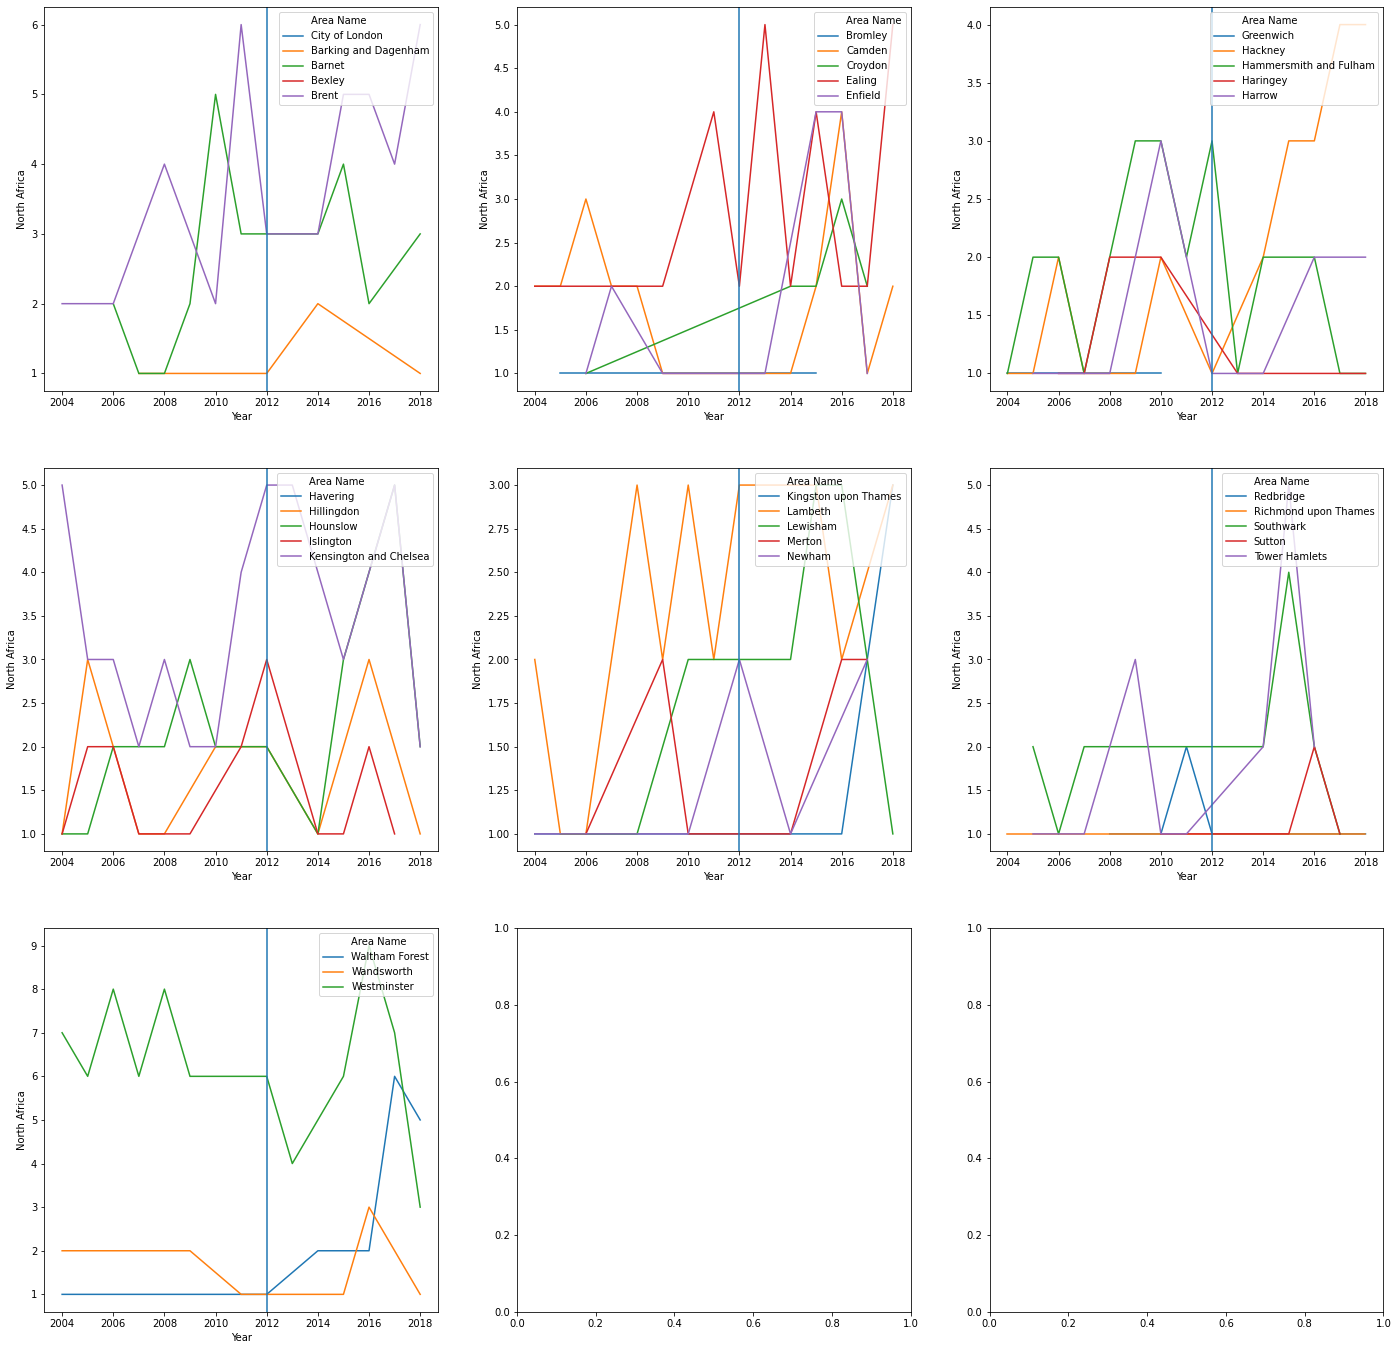

In [181]:
plot_in_batches(df, "North Africa")

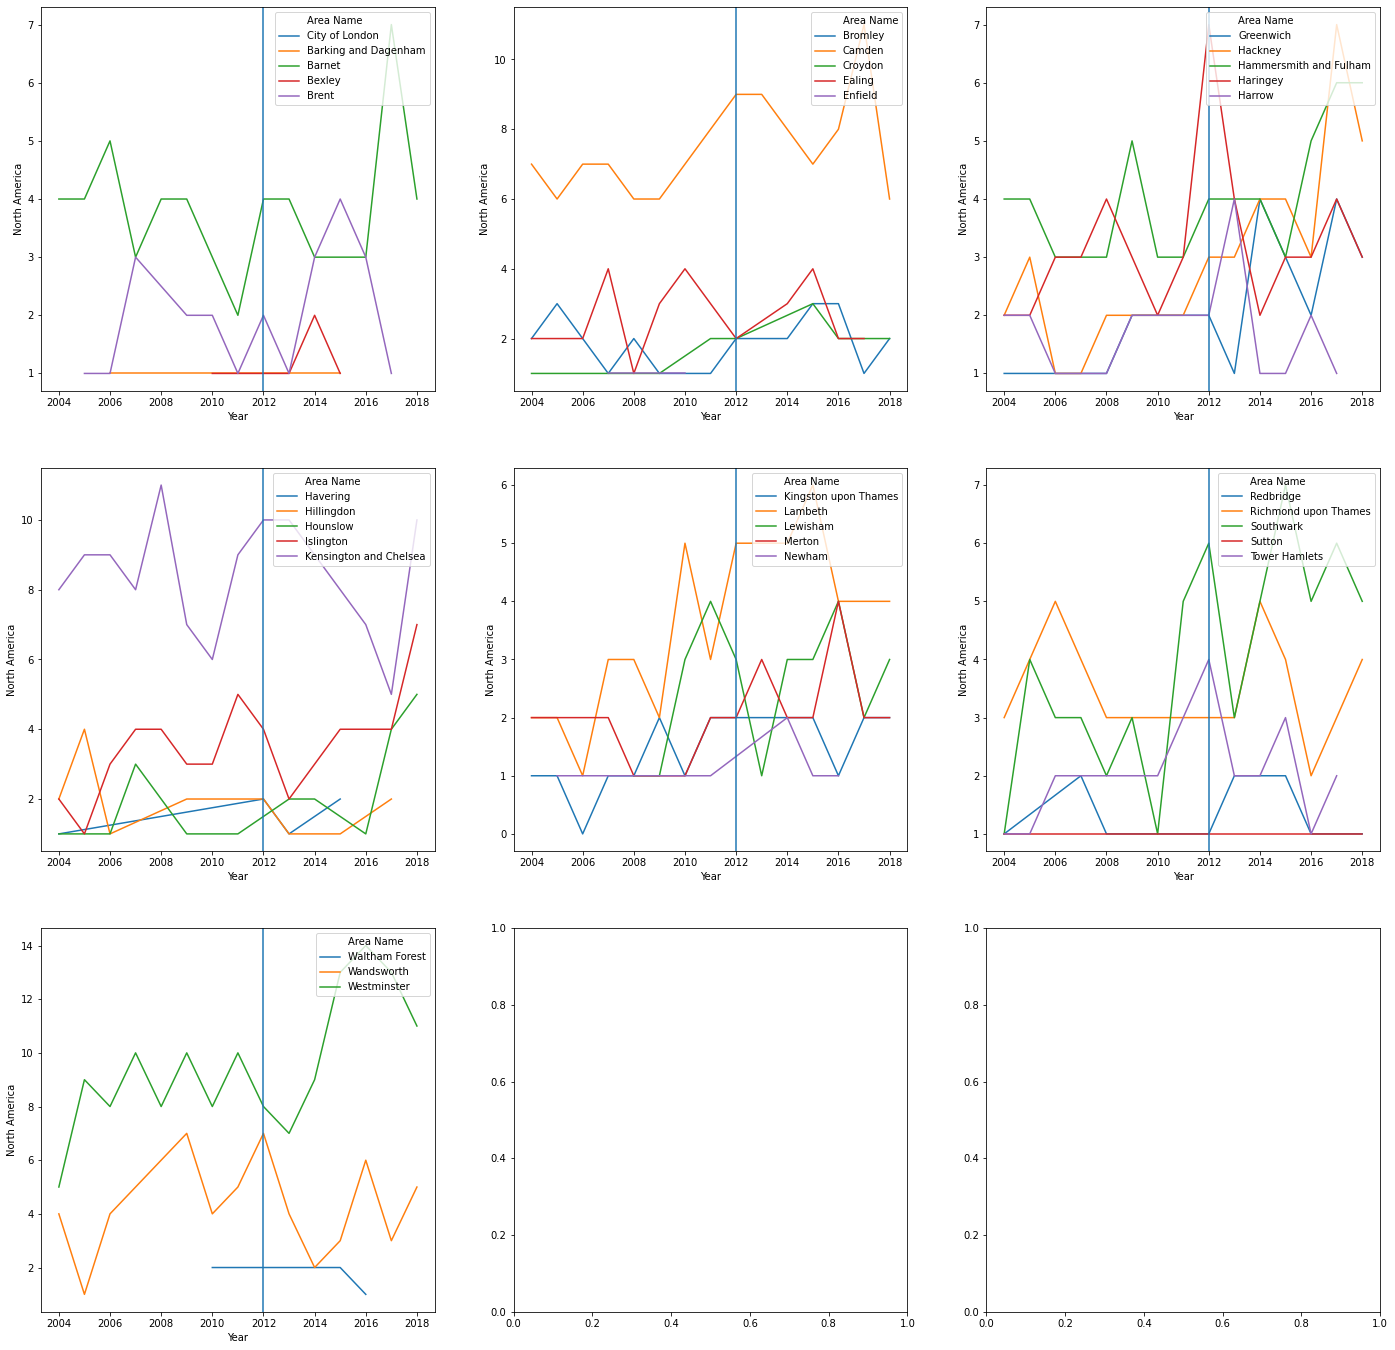

In [182]:
plot_in_batches(df, "North America")

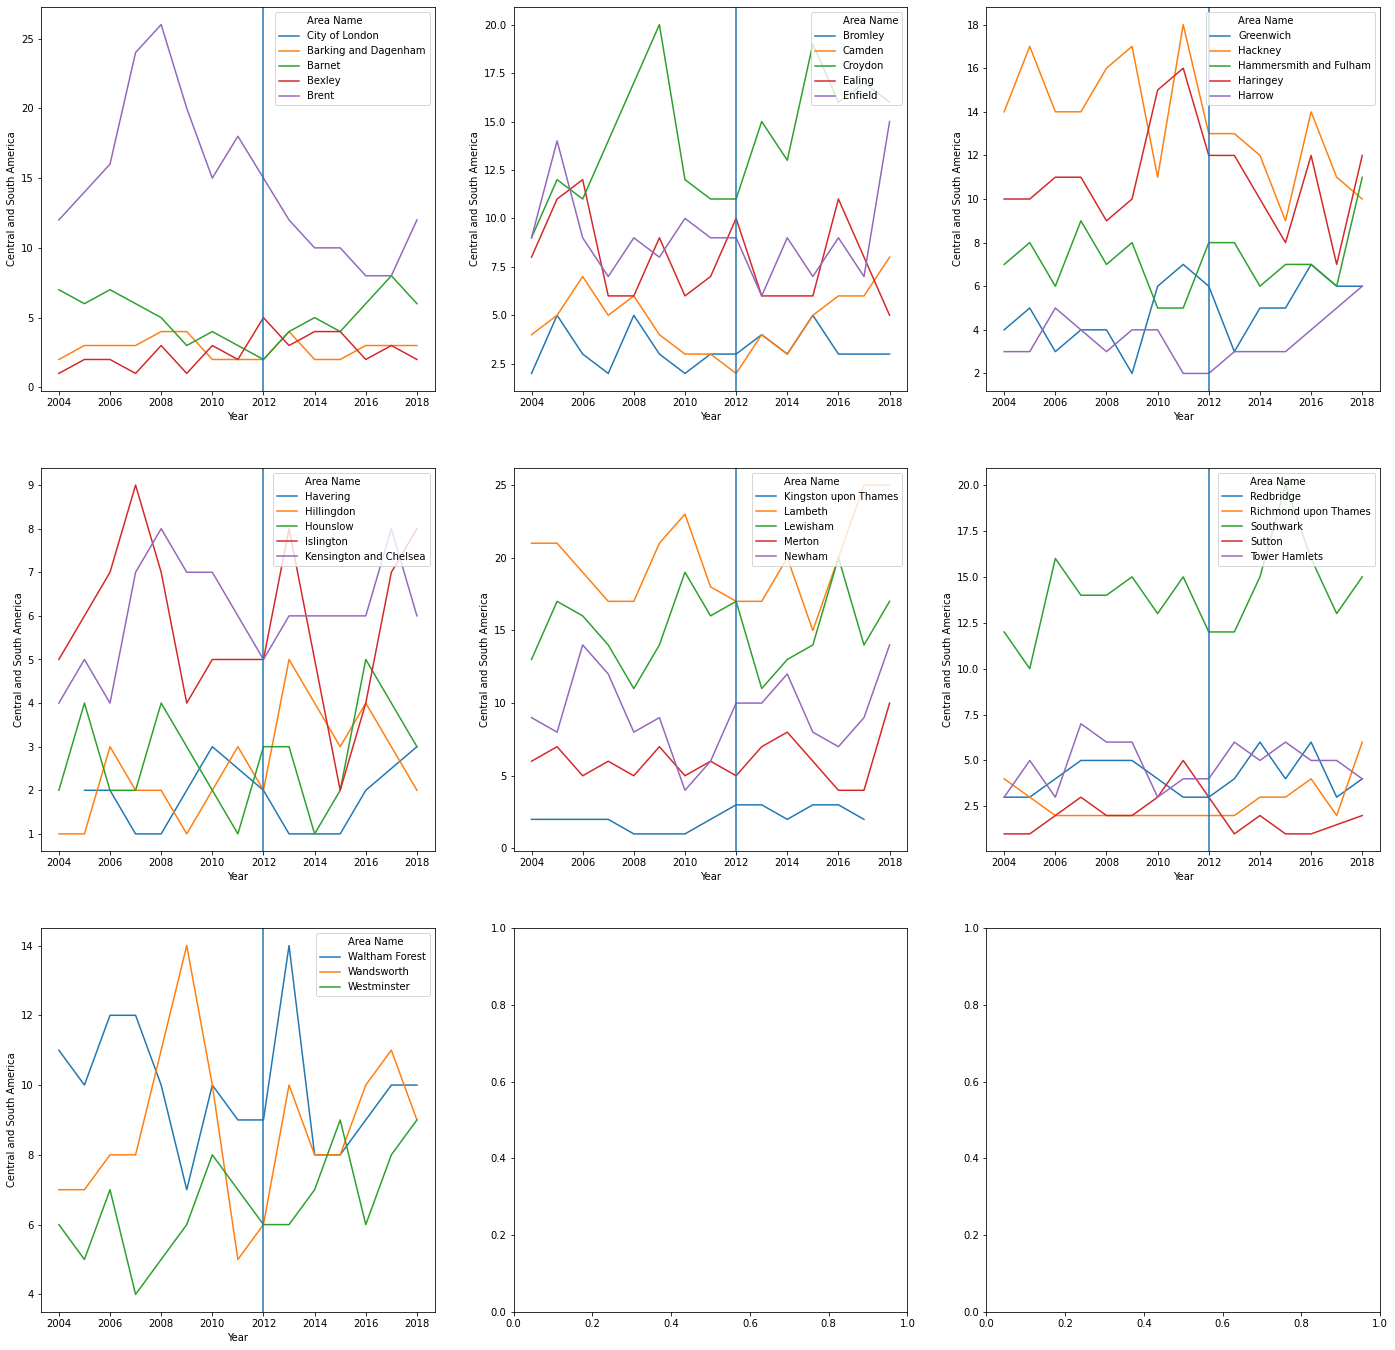

In [183]:
plot_in_batches(df, "Central and South America")

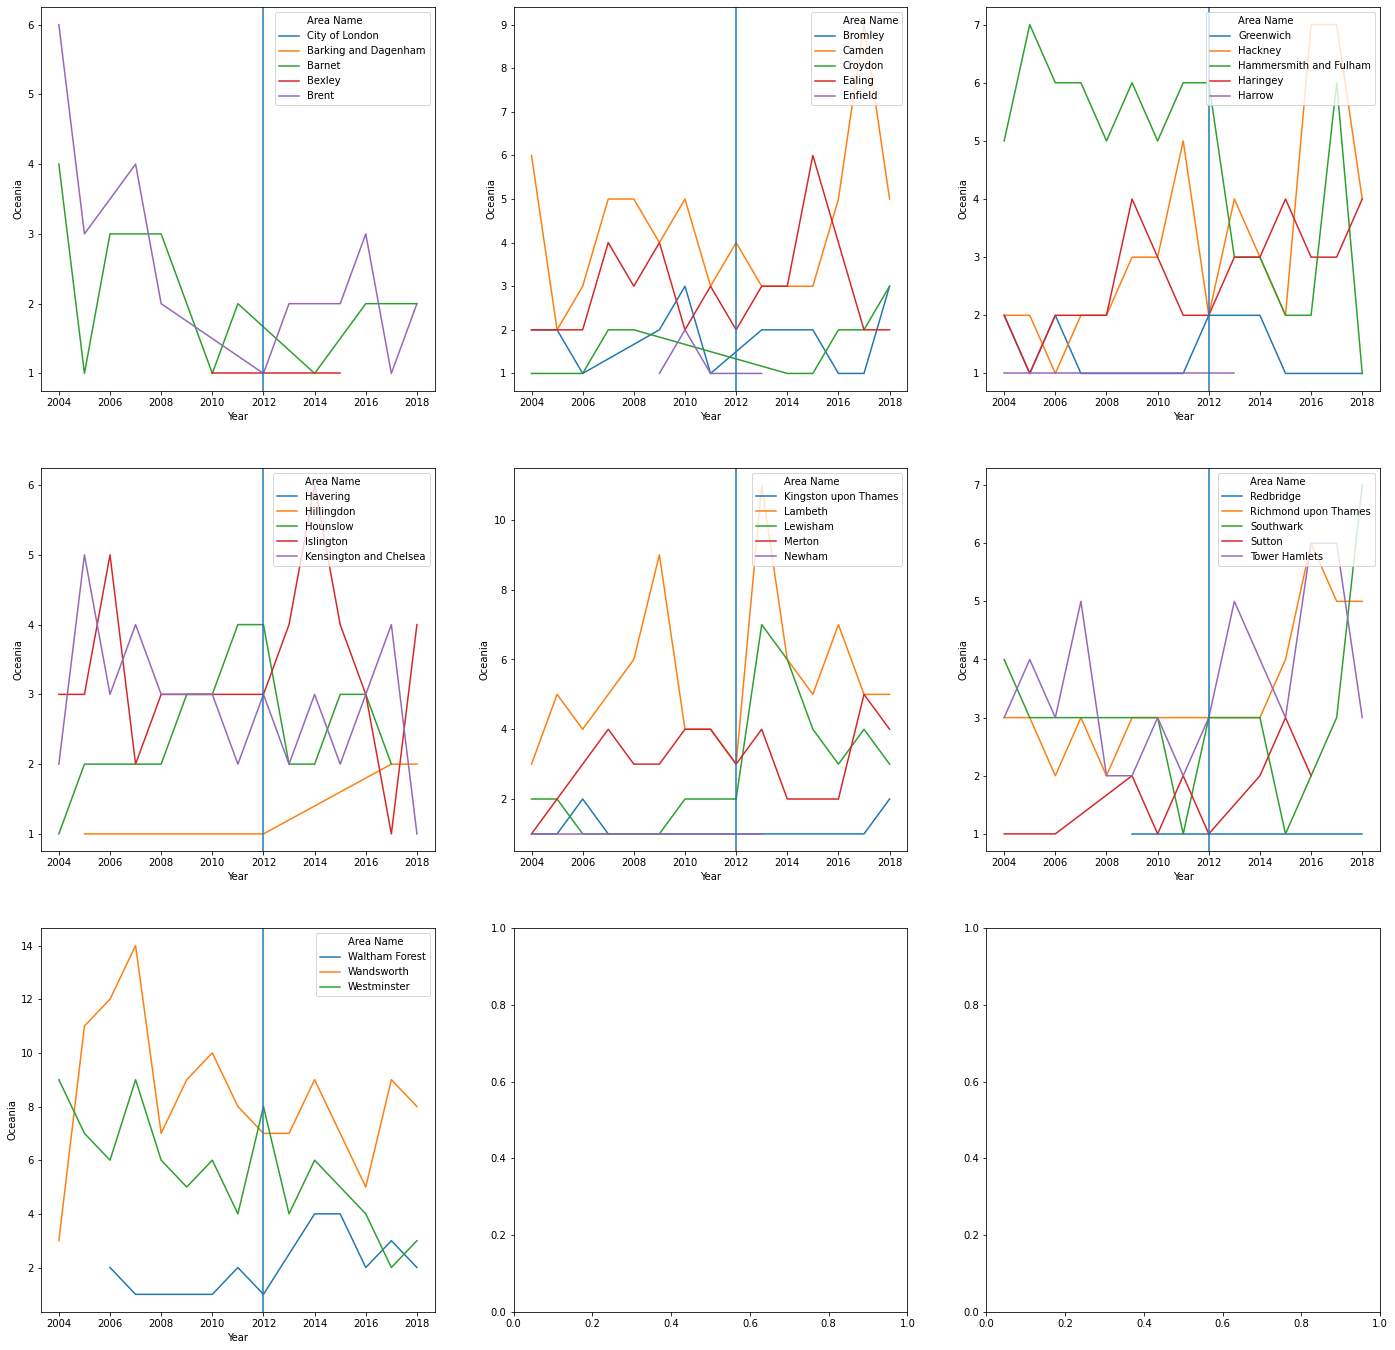

In [184]:
plot_in_batches(df, "Oceania")